In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
#we defined y as list that has 6599 edible mushrooms and 3400 poisnous mushrooms
y = [0] * 6599 + [1] * 3400
#We used class_weights=balanced to adjust the weights inversly proportional to the class frequencies
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
#We coneverted the weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.7576147901197151), 1: np.float64(1.4704411764705883)}


In [ ]:
import tensorflow as tf

DATASET_PATH = "/content/drive/MyDrive/archive/edibility_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
#creating training data set with 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)
#creating validation data set with 80/20 split
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# optimizing performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 9999 files belonging to 2 classes.
Using 8000 files for training.
Found 9999 files belonging to 2 classes.
Using 1999 files for validation.


In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# We used ResNet50 base model for transfer learning:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#We Froze the model to prevet updates
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Displayed model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Training the model on our mushroom dataset
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 279s 112ms/step - accuracy: 0.6338 - loss: 0.6949 - val_accuracy: 0.7774 - val_loss: 0.4982
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7561 - loss: 0.5003 - val_accuracy: 0.7889 - val_loss: 0.4625
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7744 - loss: 0.4613 - val_accuracy: 0.8084 - val_loss: 0.4228
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8132 - loss: 0.4199 - val_accuracy: 0.7949 - val_loss: 0.4352
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8217 - loss: 0.3861 - val_accuracy: 0.8094 - val_loss: 0.4136


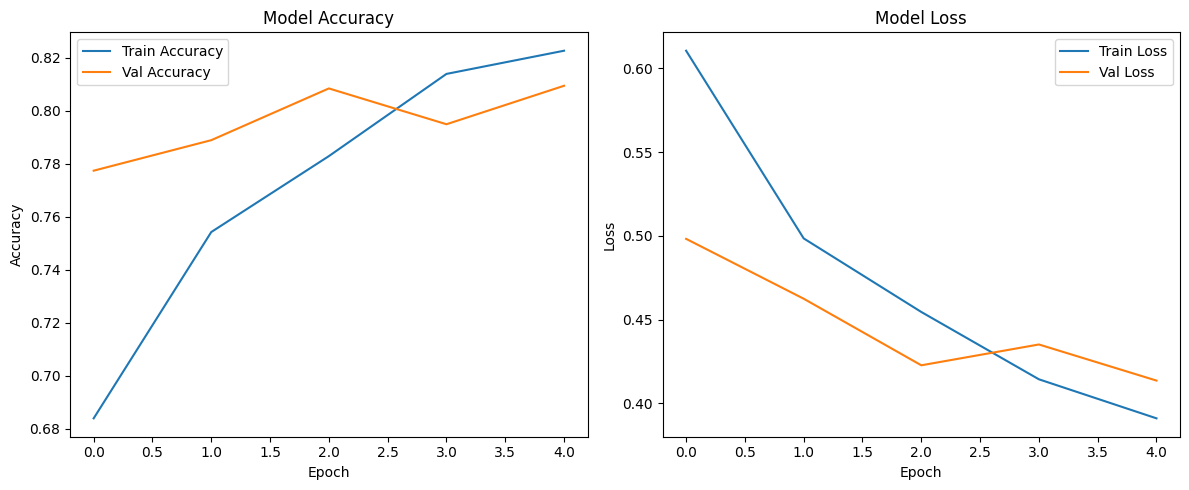

In [11]:
import matplotlib.pyplot as plt

# We extracted the metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

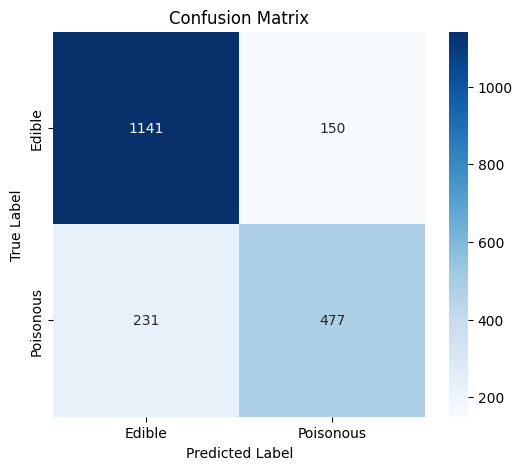

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# true and predicted lists
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())

# Classification report
print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
base_model.trainable = True
# in order to fine tune we froze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False
from tensorflow.keras.optimizers import Adam
#we recompiled the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
#trained the model on our dataset
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.8238 - loss: 0.4265 - val_accuracy: 0.8049 - val_loss: 0.4292
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9286 - loss: 0.2194 - val_accuracy: 0.8129 - val_loss: 0.4451
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9724 - loss: 0.1256 - val_accuracy: 0.8164 - val_loss: 0.4688
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9922 - loss: 0.0608 - val_accuracy: 0.8124 - val_loss: 0.5458
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9978 - loss: 0.0268 - val_accuracy: 0.8144 - val_loss: 0.6036


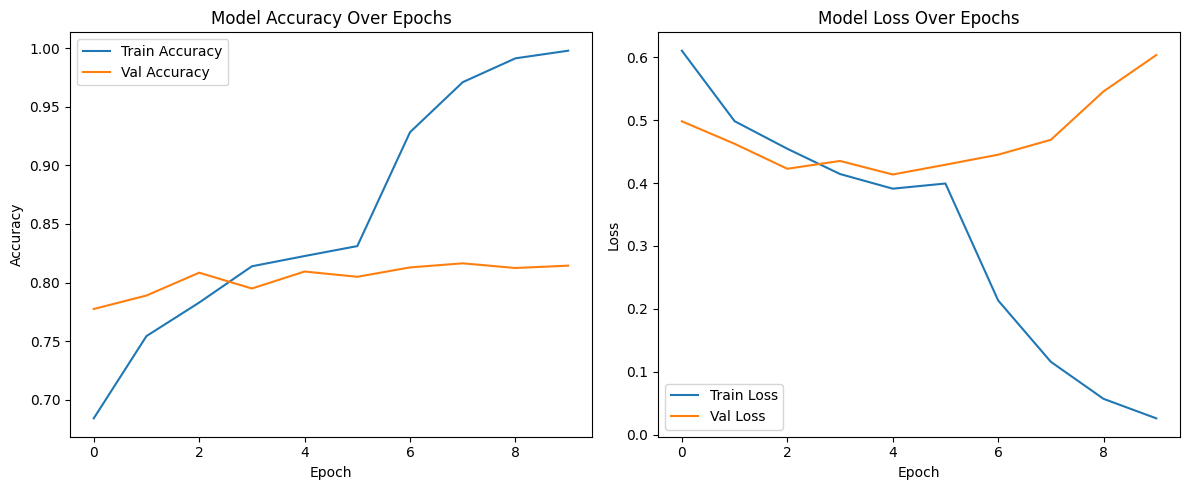

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

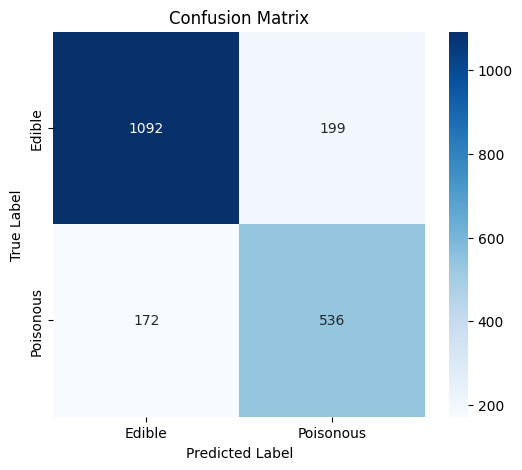

In [ ]:
import matplotlib.pyplot as plt

# Combining training and fine-tuning metrics
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
# true and predicted lists
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.8214107053526764
Precision: 0.7407407407407407
Recall: 0.7627118644067796
F1-score: 0.7515657620041754

Classification Report:
              precision    recall  f1-score   support

      Edible       0.87      0.85      0.86      1291
   Poisonous       0.74      0.76      0.75       708

    accuracy                           0.82      1999
   macro avg       0.80      0.81      0.81      1999
weighted avg       0.82      0.82      0.82      1999



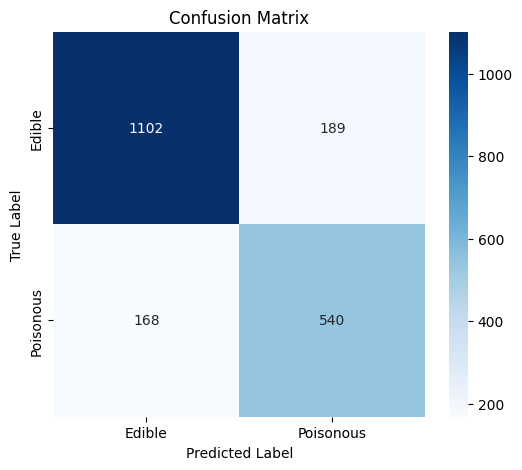

In [10]:
import os
import sys
import contextlib
import warnings
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import logging
# we implemented some code that can help us get rid of the tensorflow system logs and warnings in order to focus on the necessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras import layers, models

logging.getLogger('tensorflow').setLevel(logging.ERROR)

def representative_dataset_gen():
    for images, _ in train_ds.take(100):
        yield [images.numpy()]

class CompleteSilence:
    def write(self, msg):
        pass
    def flush(self):
        pass
#Model quantization
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(CompleteSilence()), contextlib.redirect_stderr(CompleteSilence()):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    quantized_tflite_model = converter.convert()

# Save quantized model to file
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
# used TF.lite interpreter
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_true = [] #true list
y_pred = [] #predicted list

# We ran inference on validation set
for images, labels in val_ds:
    for i in range(images.shape[0]):
        input_data = images[i].numpy()
        input_data = np.expand_dims(input_data, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_true.append(labels[i].numpy())
        y_pred.append((output_data > 0.5).astype("int").flatten()[0])

#Print Scores and Confusion matrix
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()